In [27]:
import pandas as pd

# Originele data inlezen
raw_df = pd.read_csv("../sensor_data/flowrate_basin.csv", parse_dates=["Time"])
raw_df = raw_df[(raw_df["Time"] >= "2023-10-25") & (raw_df["Time"] <= "2025-02-19")]

In [28]:
import pandas as pd
from datetime import timedelta

# Laad CSV en parse Time als datetime
flowrate_basin = pd.read_csv("../sensor_data/flowrate_basin.csv", parse_dates=["Time"])

# Controleer of 'Time' kolom datetime is, anders omzetten
if not pd.api.types.is_datetime64_any_dtype(flowrate_basin['Time']):
    flowrate_basin['Time'] = pd.to_datetime(flowrate_basin['Time'])

# Haal de datum uit de 'Time' kolom (zonder tijdcomponent)
flowrate_basin['Date'] = pd.to_datetime(flowrate_basin['Time'].dt.date)

flowrate_basin = flowrate_basin[(flowrate_basin['Date'] >= '2023-10-25') & (flowrate_basin['Date'] <= '2025-02-19')]

# Verwijder NaN en extreme waarden
flowrate_basin = flowrate_basin.dropna(subset=['flowrate_basin'])
rolling_median = flowrate_basin['flowrate_basin'].rolling(window=700, center=True).median()
diff = (flowrate_basin['flowrate_basin'] - rolling_median).abs()
flowrate_basin = flowrate_basin[diff < 0.1]

# Groepeer op dag (gemiddelde flow per dag)
daggemiddelden = flowrate_basin.groupby('Date')['flowrate_basin'].mean().reset_index()

# Maak 'Week' kolom op maat:
cutoff = pd.to_datetime("2023-10-30")
daggemiddelden['Week'] = daggemiddelden['Date'].apply(
    lambda d: pd.Timestamp("2023-10-25") if d < cutoff else d - timedelta(days=d.weekday())
)

# Bereken gemiddelde per 'Week'
weekgemiddelden = daggemiddelden.groupby('Week')['flowrate_basin'].mean().reset_index()
weekgemiddelden.rename(columns={'flowrate_basin': 'weekly_flowrate'}, inplace=True)

# Merge terug op 'Week' zodat elke dag zijn weekgemiddelde krijgt
daggemiddelden = daggemiddelden.merge(weekgemiddelden, on='Week', how='left')


In [29]:
import pandas as pd
import numpy as np

# 1. Inlezen
df = pd.read_csv("../sensor_data/flowrate_basin.csv", parse_dates=["Time"])
naam_kolom = df.columns[1]

# 2. Opschonen (optioneel, alleen als je al outliers wil filteren)
df = df.dropna()
rolling_median = df[naam_kolom].rolling(window=700, center=True).median()
diff = np.abs(df[naam_kolom] - rolling_median)
threshold = 0.1
df = df[diff < threshold]

# 3. Zet tijd als index en sorteer
df = df.set_index("Time").sort_index()

# 4. Maak tijdraster op exact 10-minutenintervallen
start = df.index.min().floor("10min")
end = df.index.max().ceil("10min")
time_grid = pd.date_range(start=start, end=end, freq="10min")

# 5. Nieuwe dataframe met enkel de grid
df_grid = pd.DataFrame(index=time_grid)

# 6. Voeg originele data toe en interpoleer
df_full = pd.concat([df, df_grid], axis=0).sort_index()
df_interp = df_full.interpolate(method="time")

# 7. Selecteer enkel waarden exact op 10-minuten
df_final = df_interp.loc[time_grid].reset_index().rename(columns={"index": "Time"})

# Zorg dat 'Time' kolom datetime is (zou het al moeten zijn na voorgaande code)
df_final["Time"] = pd.to_datetime(df_final["Time"])

# Filter enkel waarden vanaf (inclusief) 25 oktober 2023
df_filtered = df_final[(df_final["Time"] >= pd.Timestamp("2023-10-25")) & (df_final["Time"] <= pd.Timestamp("2025-02-19"))]
df_filtered = df_filtered.rename(columns={"Time": "Datetime"})

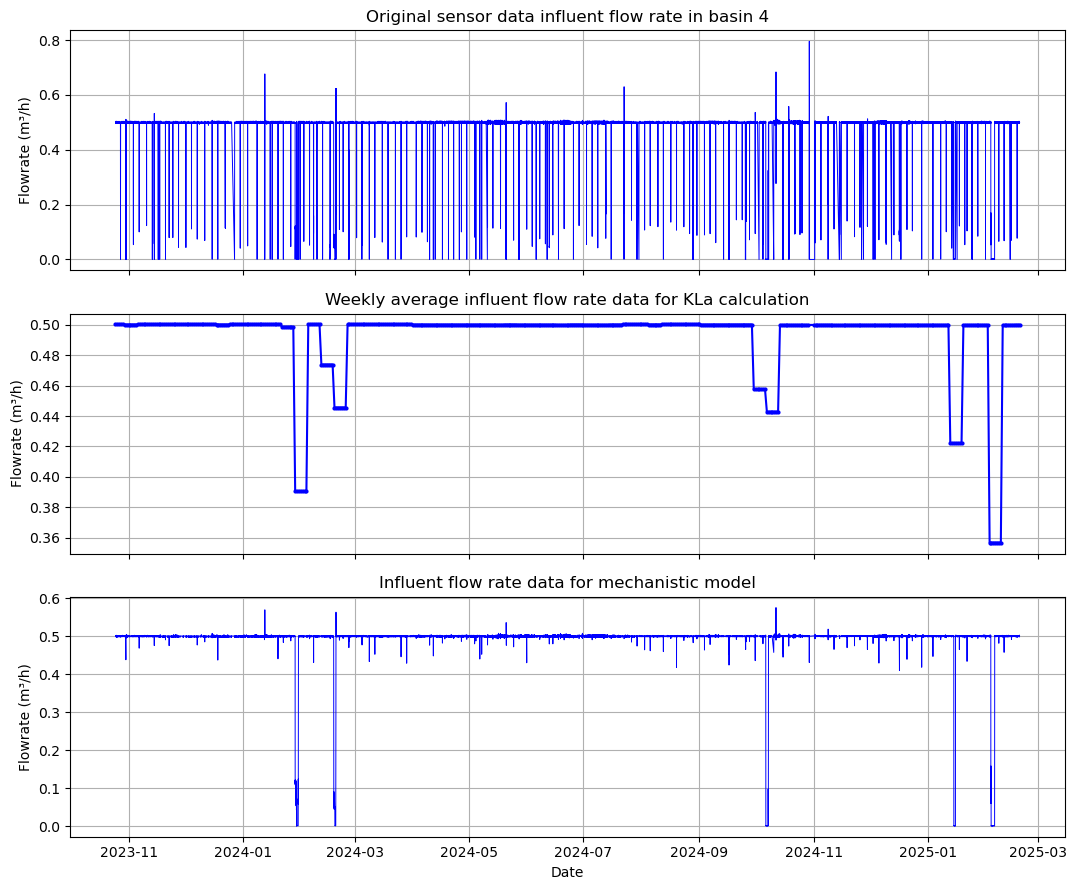

In [30]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(3, 1, figsize=(11, 9), sharex=True)

# Plot 1: originele (geschoonde) data
axes[0].plot(raw_df['Time'], raw_df['flowrate_basin'], linewidth=0.7, color='b')
axes[0].set_ylabel('Flowrate (m³/h)')
axes[0].set_title('Original sensor data influent flow rate in basin 4')
axes[0].grid(True)

# Plot 2: weekgemiddelden
axes[1].plot(daggemiddelden['Date'], daggemiddelden['weekly_flowrate'], color='b', marker='o', markersize=2, linestyle='-')
axes[1].set_ylabel('Flowrate (m³/h)')
axes[1].set_title('Weekly average influent flow rate data for KLa calculation')
axes[1].grid(True)

# Plot 3: mechanistisch
axes[2].plot(df_filtered['Datetime'], df_filtered[naam_kolom], linewidth=0.7, color='b')
axes[2].set_xlabel('Date')
axes[2].set_ylabel('Flowrate (m³/h)')
axes[2].set_title('Influent flow rate data for mechanistic model')
axes[2].grid(True)

# Layout aanpassen
plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig("FlowrateDataCombined.pdf", format='pdf', bbox_inches='tight')
plt.show()

In [31]:
import pandas as pd

# Originele data inlezen
raw_df = pd.read_csv("../sensor_data/temp_basin4.csv", parse_dates=["Time"])
raw_df = raw_df[(raw_df["Time"] >= "2023-10-25") & (raw_df["Time"] <= "2025-02-19")]

In [32]:
temp_basin4 = pd.read_csv('../sensor_data/temp_basin4.csv')

# Controleer of 'Time' kolom datetime is, anders omzetten
if not pd.api.types.is_datetime64_any_dtype(temp_basin4['Time']):
    temp_basin4['Time'] = pd.to_datetime(temp_basin4['Time'])

# Haal de datum uit de 'Time' kolom (zonder tijdcomponent)
temp_basin4['Date'] = pd.to_datetime(temp_basin4['Time'].dt.date)

temp_basin4 = temp_basin4[(temp_basin4['Date'] >= '2023-10-25') & (temp_basin4['Date'] <= '2025-02-19')]

temp_basin4 = temp_basin4.dropna()
temp_basin4 = temp_basin4[temp_basin4['temp_basin4'] != 0]
temp_basin4 = temp_basin4[temp_basin4['temp_basin4'] < 30]

rolling_median = temp_basin4['temp_basin4'].rolling(window=300, center=True).median()
diff = np.abs(temp_basin4['temp_basin4'] - rolling_median)
threshold = 2
temp_basin4 = temp_basin4[diff < threshold]

gem_dagelijks_temp = temp_basin4.groupby('Date')['temp_basin4'].mean().reset_index()

In [33]:
# Laad CSV-bestand
df = pd.read_csv("../sensor_data/temp_basin4.csv", parse_dates=["Time"])

# Juiste kolomnaam
naam_kolom = df.columns[1]

# 0-waarden
df = df.dropna()
df = df[df[naam_kolom] != 0]
df = df[df[naam_kolom] < 30]

rolling_median = df[naam_kolom].rolling(window=300, center=True).median()
diff = np.abs(df[naam_kolom] - rolling_median)
threshold = 2
df = df[diff < threshold]

# 3. Zet tijd als index en sorteer
df = df.set_index("Time").sort_index()

# 4. Maak tijdraster op exact 10-minutenintervallen
start = df.index.min().floor("10min")
end = df.index.max().ceil("10min")
time_grid = pd.date_range(start=start, end=end, freq="10min")

# 5. Nieuwe dataframe met enkel de grid
df_grid = pd.DataFrame(index=time_grid)

# 6. Voeg originele data toe en interpoleer
df_full = pd.concat([df, df_grid], axis=0).sort_index()
df_interp = df_full.interpolate(method="time")

# 7. Selecteer enkel waarden exact op 10-minuten
df_final = df_interp.loc[time_grid].reset_index().rename(columns={"index": "Time"})

# Zorg dat 'Time' kolom datetime is (zou het al moeten zijn na voorgaande code)
df_final["Time"] = pd.to_datetime(df_final["Time"])

# Filter enkel waarden vanaf (inclusief) 25 oktober 2023
df_filtered = df_final[(df_final["Time"] >= pd.Timestamp("2023-10-25")) & (df_final["Time"] <= pd.Timestamp("2025-02-19"))]
df_filtered = df_filtered.rename(columns={"Time": "Datetime"})

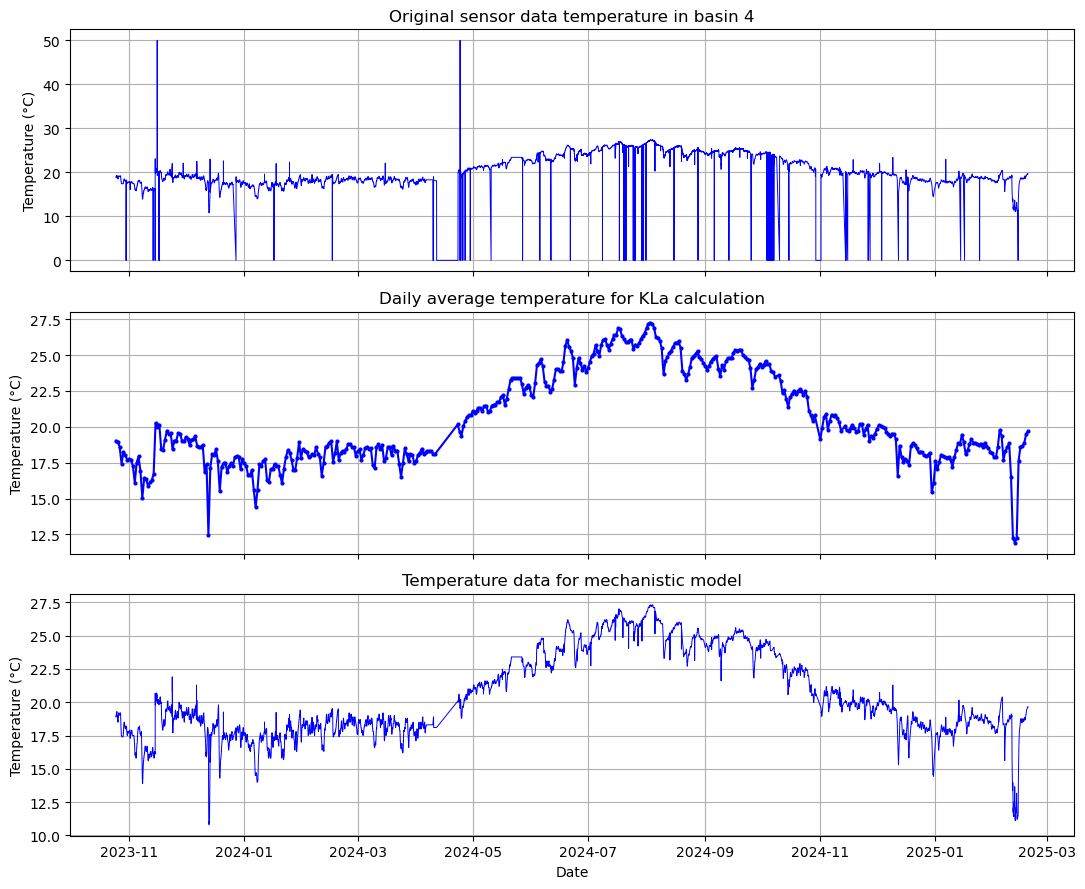

In [34]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(3, 1, figsize=(11, 9), sharex=True)

# Plot 1: originele (geschoonde) data
axes[0].plot(raw_df['Time'], raw_df['temp_basin4'], linewidth=0.7, color='b')
axes[0].set_ylabel('Temperature (°C)')
axes[0].set_title('Original sensor data temperature in basin 4')
axes[0].grid(True)

# Plot 2: weekgemiddelden
axes[1].plot(gem_dagelijks_temp['Date'], gem_dagelijks_temp['temp_basin4'], color='b', marker='o', markersize=2, linestyle='-')
axes[1].set_ylabel('Temperature (°C)')
axes[1].set_title('Daily average temperature for KLa calculation')
axes[1].grid(True)

# Plot 3: mechanistisch
axes[2].plot(df_filtered['Datetime'], df_filtered[naam_kolom], linewidth=0.7, color='b')
axes[2].set_xlabel('Date')
axes[2].set_ylabel('Temperature (°C)')
axes[2].set_title('Temperature data for mechanistic model')
axes[2].grid(True)

# Layout aanpassen
plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig("TemperatureDataCombined.pdf", format='pdf', bbox_inches='tight')
plt.show()

In [35]:
import pandas as pd

# Originele data inlezen
raw_df = pd.read_csv("../sensor_data/DO_basin4.csv", parse_dates=["Time"])
raw_df = raw_df[(raw_df["Time"] >= "2023-10-25") & (raw_df["Time"] <= "2025-02-19")]

In [36]:
from scipy.stats import trim_mean

# Laad CSV-bestand
DO_basin4 = pd.read_csv("../sensor_data/DO_basin4.csv")

# Controleer of 'Time' kolom datetime is, anders omzetten
if not pd.api.types.is_datetime64_any_dtype(DO_basin4['Time']):
    DO_basin4['Time'] = pd.to_datetime(DO_basin4['Time'])

# Haal de datum uit de 'Time' kolom (zonder tijdcomponent)
DO_basin4['Date'] = pd.to_datetime(DO_basin4['Time'].dt.date)

DO_basin4 = DO_basin4[(DO_basin4['Date'] >= '2023-10-25')& (DO_basin4['Date'] <= '2025-02-19')]

# 0-waarden
DO_basin4 = DO_basin4.dropna()
DO_basin4 = DO_basin4[DO_basin4['DO_basin4'] != 0]
DO_basin4 = DO_basin4[DO_basin4['DO_basin4'] < 3.5]

rolling_median = DO_basin4['DO_basin4'].rolling(window=150, center=True).median()
diff = np.abs(DO_basin4['DO_basin4'] - rolling_median)
threshold = 0.5
DO_basin4 = DO_basin4[diff < threshold]

def trimmed_daily_mean(values, proportion_to_cut=0.00000005):
    return trim_mean(values, proportiontocut=proportion_to_cut)

# Pas deze functie toe in je groupby
gem_dagelijks_DO4 = DO_basin4.groupby('Date')['DO_basin4'].apply(trimmed_daily_mean).reset_index()

In [37]:
from scipy.stats import trim_mean
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Laad CSV-bestand
DO_basin4 = pd.read_csv("../sensor_data/DO_basin4.csv")

# Controleer of 'Time' kolom datetime is, anders omzetten
if not pd.api.types.is_datetime64_any_dtype(DO_basin4['Time']):
    DO_basin4['Time'] = pd.to_datetime(DO_basin4['Time'])

# 0-waarden
DO_basin4 = DO_basin4.dropna()
DO_basin4 = DO_basin4[DO_basin4['DO_basin4'] != 0]
DO_basin4 = DO_basin4[DO_basin4['DO_basin4'] < 3.5]
DO_basin4 = DO_basin4[~((DO_basin4["Time"] >= "2024-04-06") & (DO_basin4["Time"] <= "2024-04-30"))]

rolling_median = DO_basin4['DO_basin4'].rolling(window=150, center=True).median()
diff = np.abs(DO_basin4['DO_basin4'] - rolling_median)
threshold = 0.5
DO_basin4 = DO_basin4[diff < threshold]

# Werk met een kopie om veilig te zijn
dfDO4 = DO_basin4.copy()

# 3. Zet tijd als index en sorteer
df = dfDO4.set_index("Time").sort_index()

# 4. Maak tijdraster op exact 10-minutenintervallen
start = df.index.min().floor("10min")
end = df.index.max().ceil("10min")
time_grid = pd.date_range(start=start, end=end, freq="10min")

# 5. Nieuwe dataframe met enkel de grid
df_grid = pd.DataFrame(index=time_grid)

# 6. Voeg originele data toe en interpoleer
df_full = pd.concat([df, df_grid], axis=0).sort_index()
df_interp = df_full.interpolate(method="time")

# 7. Selecteer enkel waarden exact op 10-minuten
df_final = df_interp.loc[time_grid].reset_index().rename(columns={"index": "Time"})

# Zorg dat 'Time' kolom datetime is (zou het al moeten zijn na voorgaande code)
df_final["Time"] = pd.to_datetime(df_final["Time"])

# Filter enkel waarden vanaf (inclusief) 25 oktober 2023
df_filtered = df_final[(df_final["Time"] >= pd.Timestamp("2023-10-25")) & (df_final["Time"] <= pd.Timestamp("2025-02-19"))]
df_filtered = df_filtered.rename(columns={"Time": "Datetime"})

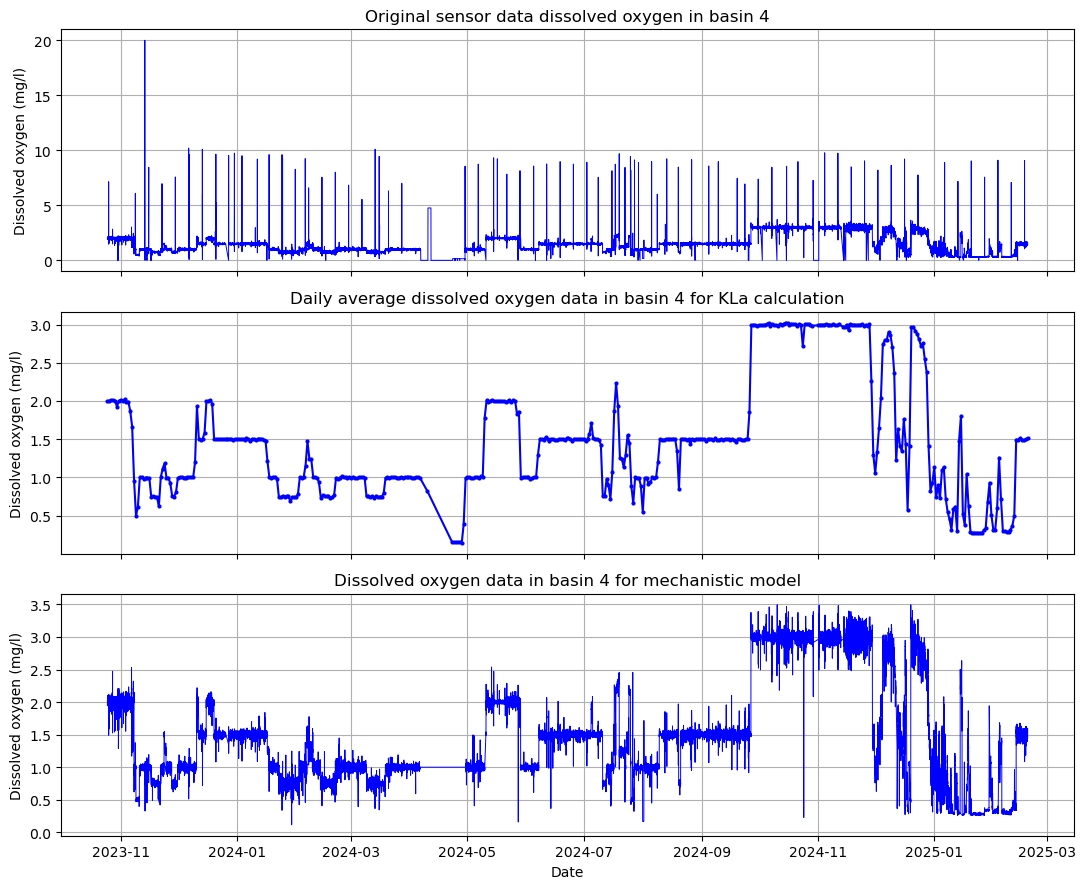

In [38]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(3, 1, figsize=(11, 9), sharex=True)

# Plot 1: originele (geschoonde) data
axes[0].plot(raw_df['Time'], raw_df['DO_basin4'], linewidth=0.7, color='b')
axes[0].set_ylabel('Dissolved oxygen (mg/l)')
axes[0].set_title('Original sensor data dissolved oxygen in basin 4')
axes[0].grid(True)

# Plot 2: weekgemiddelden
axes[1].plot(gem_dagelijks_DO4['Date'], gem_dagelijks_DO4['DO_basin4'], color='b', marker='o', markersize=2, linestyle='-')
axes[1].set_ylabel('Dissolved oxygen (mg/l)')
axes[1].set_title('Daily average dissolved oxygen data in basin 4 for KLa calculation')
axes[1].grid(True)

# Plot 3: mechanistisch
axes[2].plot(df_filtered['Datetime'], df_filtered['DO_basin4'], linewidth=0.7, color='b')
axes[2].set_xlabel('Date')
axes[2].set_ylabel('Dissolved oxygen (mg/l)')
axes[2].set_title('Dissolved oxygen data in basin 4 for mechanistic model')
axes[2].grid(True)

# Layout aanpassen
plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig("OxygenBasin4DataCombined.pdf", format='pdf', bbox_inches='tight')
plt.show()

In [39]:
import pandas as pd

# Originele data inlezen
raw_df = pd.read_csv("../sensor_data/DO_basin5.csv", parse_dates=["Time"])
raw_df = raw_df[(raw_df["Time"] >= "2023-10-25") & (raw_df["Time"] <= "2025-02-19")]

In [40]:
# Laad CSV-bestand
DO_basin5 = pd.read_csv("../sensor_data/DO_basin5.csv")

# Controleer of 'Time' kolom datetime is, anders omzetten
if not pd.api.types.is_datetime64_any_dtype(DO_basin5['Time']):
    DO_basin5['Time'] = pd.to_datetime(DO_basin5['Time'])

# Haal de datum uit de 'Time' kolom (zonder tijdcomponent)
DO_basin5['Date'] = pd.to_datetime(DO_basin5['Time'].dt.date)

DO_basin5 = DO_basin5[(DO_basin5['Date'] >= '2023-10-25') & (DO_basin5['Date'] <= '2025-02-19')]

# 0-waarden
DO_basin5 = DO_basin5.dropna()
DO_basin5 = DO_basin5[DO_basin5['DO_basin5'] != 0]
DO_basin5 = DO_basin5[DO_basin5['DO_basin5'] < 3.5]

rolling_median = DO_basin5['DO_basin5'].rolling(window=150, center=True).median()
diff = np.abs(DO_basin5['DO_basin5'] - rolling_median)
threshold = 0.5
DO_basin5 = DO_basin5[diff < threshold]

def trimmed_daily_mean(values, proportion_to_cut=0.00000005):
    return trim_mean(values, proportiontocut=proportion_to_cut)

# Pas deze functie toe in je groupby
gem_dagelijks_DO5 = DO_basin5.groupby('Date')['DO_basin5'].apply(trimmed_daily_mean).reset_index()

In [41]:
# Laad CSV-bestand
DO_basin5 = pd.read_csv("../sensor_data/DO_basin5.csv")

# Controleer of 'Time' kolom datetime is, anders omzetten
if not pd.api.types.is_datetime64_any_dtype(DO_basin5['Time']):
    DO_basin5['Time'] = pd.to_datetime(DO_basin5['Time'])

# 0-waarden
DO_basin5 = DO_basin5.dropna()
DO_basin5 = DO_basin5[DO_basin5['DO_basin5'] != 0]
DO_basin5 = DO_basin5[DO_basin5['DO_basin5'] < 3.5]
DO_basin5 = DO_basin5[~((DO_basin5["Time"] >= "2024-04-06") & (DO_basin5["Time"] <= "2024-04-30"))]

rolling_median = DO_basin5['DO_basin5'].rolling(window=150, center=True).median()
diff = np.abs(DO_basin5['DO_basin5'] - rolling_median)
threshold = 0.5
DO_basin5 = DO_basin5[diff < threshold]

# Werk met een kopie om veilig te zijn
dfDO5 = DO_basin5.copy()

# 3. Zet tijd als index en sorteer
df = dfDO5.set_index("Time").sort_index()

# 4. Maak tijdraster op exact 10-minutenintervallen
start = df.index.min().floor("10min")
end = df.index.max().ceil("10min")
time_grid = pd.date_range(start=start, end=end, freq="10min")

# 5. Nieuwe dataframe met enkel de grid
df_grid = pd.DataFrame(index=time_grid)

# 6. Voeg originele data toe en interpoleer
df_full = pd.concat([df, df_grid], axis=0).sort_index()
df_interp = df_full.interpolate(method="time")

# 7. Selecteer enkel waarden exact op 10-minuten
df_final = df_interp.loc[time_grid].reset_index().rename(columns={"index": "Time"})

# Zorg dat 'Time' kolom datetime is (zou het al moeten zijn na voorgaande code)
df_final["Time"] = pd.to_datetime(df_final["Time"])

# Filter enkel waarden vanaf (inclusief) 25 oktober 2023
df_filtered = df_final[(df_final["Time"] >= pd.Timestamp("2023-10-25")) & (df_final["Time"] <= pd.Timestamp("2025-02-19"))]
df_filtered = df_filtered.rename(columns={"Time": "Datetime"})

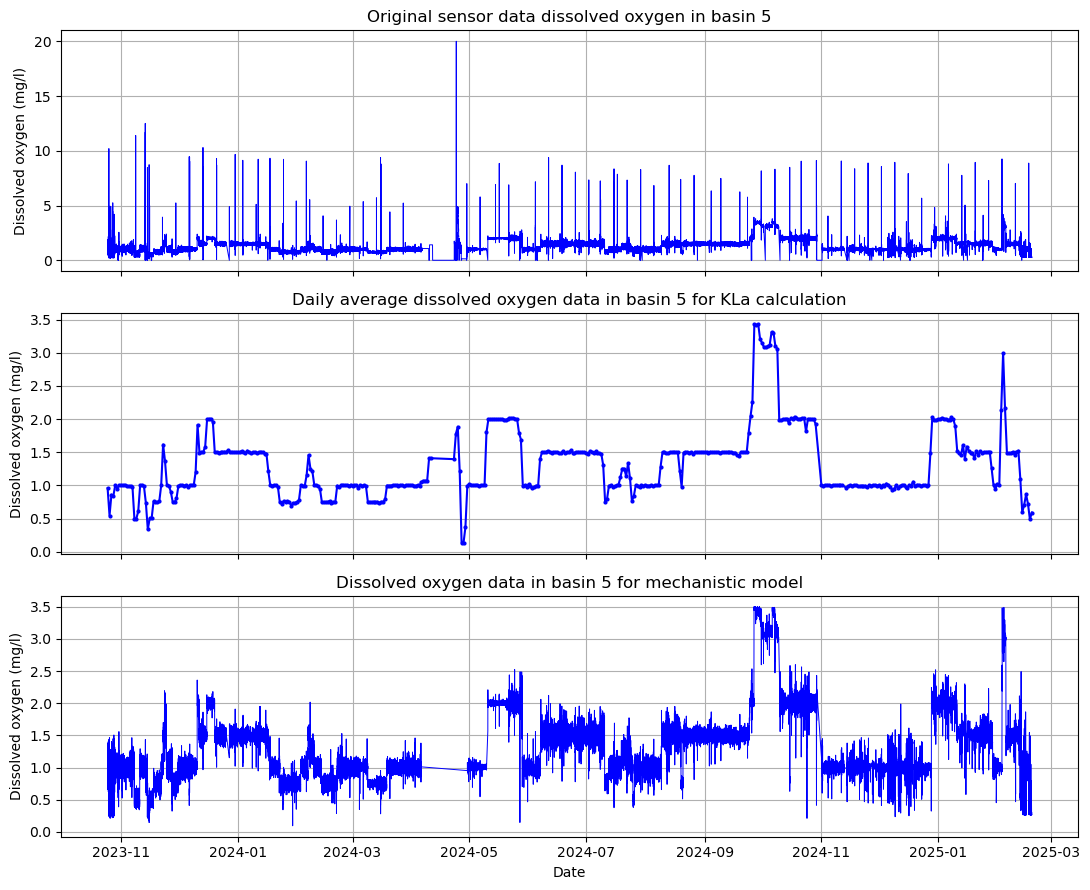

In [42]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(3, 1, figsize=(11, 9), sharex=True)

# Plot 1: originele (geschoonde) data
axes[0].plot(raw_df['Time'], raw_df['DO_basin5'], linewidth=0.7, color='b')
axes[0].set_ylabel('Dissolved oxygen (mg/l)')
axes[0].set_title('Original sensor data dissolved oxygen in basin 5')
axes[0].grid(True)

# Plot 2: weekgemiddelden
axes[1].plot(gem_dagelijks_DO5['Date'], gem_dagelijks_DO5['DO_basin5'], color='b', marker='o', markersize=2, linestyle='-')
axes[1].set_ylabel('Dissolved oxygen (mg/l)')
axes[1].set_title('Daily average dissolved oxygen data in basin 5 for KLa calculation')
axes[1].grid(True)

# Plot 3: mechanistisch
axes[2].plot(df_filtered['Datetime'], df_filtered['DO_basin5'], linewidth=0.7, color='b')
axes[2].set_xlabel('Date')
axes[2].set_ylabel('Dissolved oxygen (mg/l)')
axes[2].set_title('Dissolved oxygen data in basin 5 for mechanistic model')
axes[2].grid(True)

# Layout aanpassen
plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig("OxygenBasin5DataCombined.pdf", format='pdf', bbox_inches='tight')
plt.show()

In [43]:
import pandas as pd

# Originele data inlezen
raw_df = pd.read_csv("../sensor_data/airflowrate_basin4.csv", parse_dates=["Time"])
raw_df = raw_df[(raw_df["Time"] >= "2023-10-25") & (raw_df["Time"] <= "2025-02-19")]

In [44]:
# Laad CSV-bestand
df = pd.read_csv("../sensor_data/airflowrate_basin4.csv", parse_dates=["Time"])

# Juiste kolomnaam
naam_kolom = df.columns[1]

# 0-waarden
df = df.dropna()
df = df[df[naam_kolom] != 0]
df = df[(df["Time"] >= "2023-10-25") & (df["Time"] <= "2025-02-19")]

# Controleer of 'Time' kolom datetime is, anders omzetten
if not pd.api.types.is_datetime64_any_dtype(df['Time']):
    df['Time'] = pd.to_datetime(df['Time'])

# Haal de datum uit de 'Time' kolom (zonder tijdcomponent)
df['Date'] = df['Time'].dt.date

# Bereken het gemiddelde van 'airflow_basin5' voor elke datum
gem_dagelijks = df.groupby('Date')['airflow_basin4'].mean().reset_index()

In [46]:
# Laad airflowdata
qair4 = pd.read_csv("../sensor_data/airflowrate_basin4.csv", parse_dates=["Time"])

# Haal juiste kolom
naam_kolom = qair4.columns[1]

# Zet Time als datetime index voor resampling
qair4 = qair4.set_index('Time')

# Lees doeldata
kLas = pd.read_csv("kla_values_2tanksincludingCODssensor.csv")
kLas['Date'] = pd.to_datetime(kLas['Date'])
doeldatums = pd.DataFrame({'Date': kLas['Date']})
doeldatums = doeldatums.set_index('Date')

# Weekgemiddelde airflow berekenen
qair4_weekly = qair4.resample('W').mean()

# Interpoleer naar doeldatums
qair4_weekly_interpol = qair4_weekly.reindex(qair4_weekly.index.union(doeldatums.index)).sort_index()
qair4_weekly_interpol = qair4_weekly_interpol.interpolate(method='time')
qair4_weekly_interpol = qair4_weekly_interpol.loc[doeldatums.index]
qair4_weekly_interpol = qair4_weekly_interpol.reset_index()

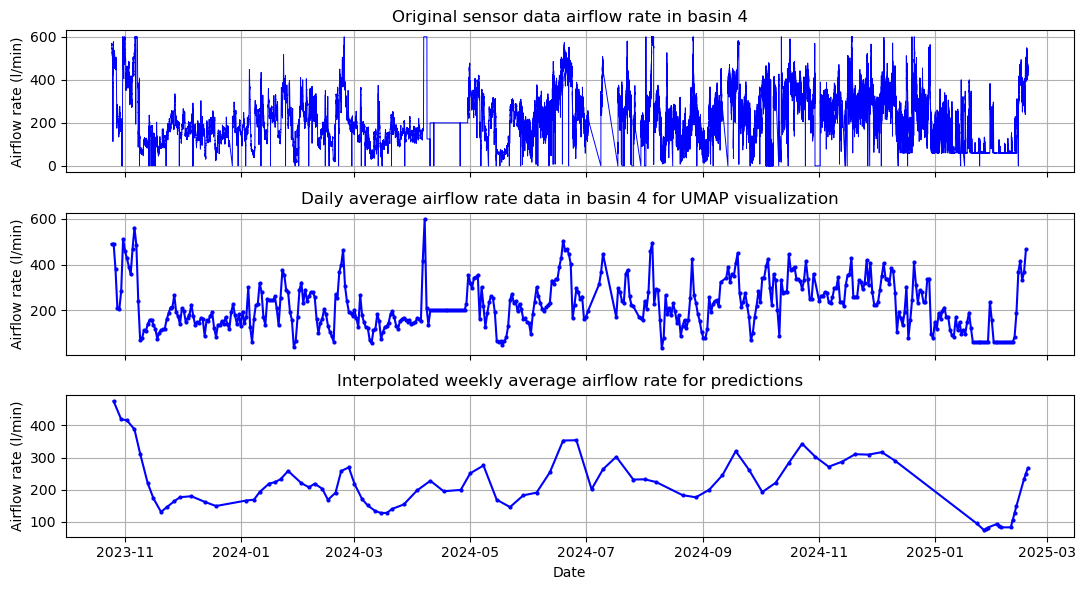

In [47]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(3, 1, figsize=(11, 6), sharex=True)

# Plot 1: originele (geschoonde) data
axes[0].plot(raw_df['Time'], raw_df['airflow_basin4'], linewidth=0.7, color='b')
axes[0].set_ylabel('Airflow rate (l/min)')
axes[0].set_title('Original sensor data airflow rate in basin 4')
axes[0].grid(True)

# Plot 2: weekgemiddelden
axes[1].plot(gem_dagelijks['Date'], gem_dagelijks['airflow_basin4'], color='b', marker='o', markersize=2, linestyle='-')
axes[1].set_ylabel('Airflow rate (l/min)')
axes[1].set_title('Daily average airflow rate data in basin 4 for UMAP visualization')
axes[1].grid(True)

# Plot 3: mechanistisch
axes[2].plot(qair4_weekly_interpol['Date'], qair4_weekly_interpol[naam_kolom], color='b', marker='o', markersize=2, linestyle='-')
axes[2].set_xlabel('Date')
axes[2].set_ylabel('Airflow rate (l/min)')
axes[2].set_title('Interpolated weekly average airflow rate for predictions')
axes[2].grid(True)

# Layout aanpassen
plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig("AirflowBasin4DataCombined.pdf", format='pdf', bbox_inches='tight')
plt.show()